# Making Bert Fast in Production

In [1]:
from datasets import load_metric, load_dataset
from transformers import pipeline, TrainingArguments, Trainer, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
import torch
from pathlib import Path
from time import perf_counter
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from huggingface_hub import notebook_login
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from torch import quantize_per_tensor
from torch.nn.quantized import QFunctional
import sys
from torch.quantization import quantize_dynamic
import os
from psutil import cpu_count
from transformers.convert_graph_to_onnx import convert
from onnxruntime import (GraphOptimizationLevel, InferenceSession,
                         SessionOptions)
from scipy.special import softmax
from onnxruntime.quantization import quantize_dynamic, QuantType

## Using BERT for Intent Detection

### using a fine-tuned model from the huggingface as a starting point

In [2]:
bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

In [3]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034818649292}]

In [4]:
clinc = load_dataset("clinc_oos", "plus")

Found cached dataset clinc_oos (C:/Users/cafbr/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [6]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

### creating a performance benchmark

In [7]:
accuracy_score = load_metric("accuracy")

C:\Users\cafbr\AppData\Local\Temp\ipykernel_13504\2323821995.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy")


In [8]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        # We'll define this later
        pass

    def compute_size(self):
        # We'll define this later
        pass
    
    def time_pipeline(self):
        # We'll define this later
        pass

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [9]:
def compute_accuracy(self):
    """This overrides the PerformanceBenchmark.compute_accuracy() method"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

In [10]:
PerformanceBenchmark.compute_accuracy = compute_accuracy

In [11]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

In [12]:
torch.save(pipe.model.state_dict(), "model.pt")

In [13]:
def compute_size(self):
    """This overrides the PerformanceBenchmark.compute_size() method"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # Calculate size in megabytes
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # Delete temporary file
    tmp_path.unlink()
    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}    

In [14]:
PerformanceBenchmark.compute_size = compute_size

In [15]:
for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 78.468
Latency (ms) - 78.106
Latency (ms) - 73.377


In [16]:
def time_pipeline(self, query="What is the pin number for my account?"):
    """This overrides the PerformanceBenchmark.time_pipeline() method"""
    latencies = []
    # Warmup
    for _ in range(10):
        _ = self.pipeline(query)
    # Timed run
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

In [17]:
PerformanceBenchmark.time_pipeline = time_pipeline

### creating a baseline: now we have a reference point

In [18]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.16
Average latency (ms) - 53.82 +\- 6.03
Accuracy on test set - 0.867


### first optimization technique: Improve compression with knowledge Distillation

In [19]:
class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [20]:
class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs_stu = model(**inputs)
        # Extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

#### Choosing a Good Student Initialization:  as the teacher is BERT, so DistilBERT is a natural candidate to initialize the student

In [21]:
student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

Loading cached processed dataset at C:\Users\cafbr\.cache\huggingface\datasets\clinc_oos\plus\1.0.0\abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1\cache-1d6ddfedcbdcd536.arrow
Loading cached processed dataset at C:\Users\cafbr\.cache\huggingface\datasets\clinc_oos\plus\1.0.0\abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1\cache-2b194f54fcbb569d.arrow
Loading cached processed dataset at C:\Users\cafbr\.cache\huggingface\datasets\clinc_oos\plus\1.0.0\abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1\cache-795caa27ea780a63.arrow


In [22]:
# using hugging face hub
notebook_login()

Token is valid.
Your token has been saved to C:\Users\cafbr\.cache\huggingface\token
Login successful


In [23]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

#### define the training arguments

In [24]:
batch_size = 8

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy = "epoch",
    num_train_epochs=5, learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01,
    push_to_hub=True)

In [25]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [26]:
num_labels = intents.num_classes
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels,
                                   id2label=id2label, label2id=label2id))

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

####  load the teacher and fine-tune

In [28]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [29]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classi

In [30]:
distilbert_trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

TrainOutput(global_step=9535, training_loss=0.6897646914306085, metrics={'train_runtime': 2206.9695, 'train_samples_per_second': 34.55, 'train_steps_per_second': 4.32, 'total_flos': 327462059107680.0, 'train_loss': 0.6897646914306085, 'epoch': 5.0})

#### now that we’ve fine-tuned DistilBERT, let’s push the model to the huggingface hub 

In [31]:
distilbert_trainer.push_to_hub("Training completed!")

Upload file pytorch_model.bin:   0%|          | 1.00/256M [00:00<?, ?B/s]

To https://huggingface.co/cafbr/distilbert-base-uncased-finetuned-clinc
   ea2e307..032950e  main -> main

To https://huggingface.co/cafbr/distilbert-base-uncased-finetuned-clinc
   032950e..d7660aa  main -> main



'https://huggingface.co/cafbr/distilbert-base-uncased-finetuned-clinc/commit/032950e69c1fa3995c74a5b2b7fc3eb0121cf5ff'

#### pulling the trained model

In [30]:
finetuned_ckpt = "cafbr/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

C:\Users\cafbr\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\cafbr\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


#### comparing the results against the baseline 

In [31]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.89
Average latency (ms) - 25.00 +\- 3.14
Accuracy on test set - 0.851


#### we’ve managed to significantly decrease the average latency (but we need to improve the accuracy)

C:\Users\cafbr\AppData\Local\Temp\ipykernel_13504\1075491845.py:16: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


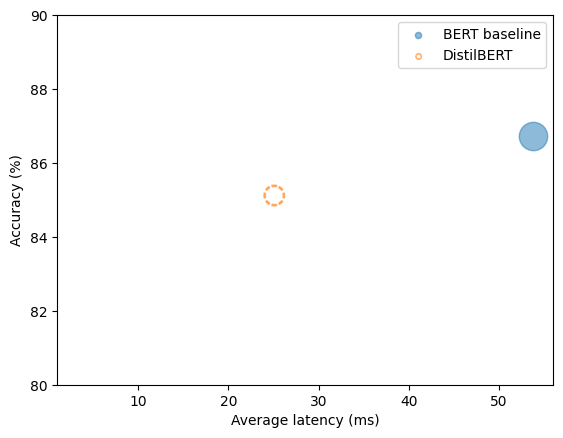

In [32]:
def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        s=df_opt["size_mb"], label=idx, alpha=0.5)

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

plot_metrics(perf_metrics, optim_type)

#### improving accuracy

In [33]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

In [34]:
# Optuna collects multiple trials as a study, so to create one we just pass the objective() function
# to study.optimize()
study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2023-04-24 11:49:06,171] A new study created in memory with name: no-name-7fdf1a44-4e69-4896-95dc-7c8c83507767
[I 2023-04-24 11:49:06,176] Trial 0 finished with value: 1049.7126251934137 and parameters: {'x': -1.297695304961421, 'y': -1.5477561036377745}. Best is trial 0 with value: 1049.7126251934137.
[I 2023-04-24 11:49:06,178] Trial 1 finished with value: 88.91799735783944 and parameters: {'x': -0.2679836885252702, 'y': 1.0062146083613666}. Best is trial 1 with value: 88.91799735783944.
[I 2023-04-24 11:49:06,179] Trial 2 finished with value: 107.25596050472825 and parameters: {'x': -0.12725297200915175, 'y': -1.013298114988014}. Best is trial 1 with value: 88.91799735783944.
[I 2023-04-24 11:49:06,180] Trial 3 finished with value: 2.543650337208613 and parameters: {'x': 1.2275898227163218, 'y': 1.6648328214950983}. Best is trial 3 with value: 2.543650337208613.
[I 2023-04-24 11:49:06,182] Trial 4 finished with value: 97.97683206206833 and parameters: {'x': -1.038905362681433, 'y

[I 2023-04-24 11:49:06,487] Trial 40 finished with value: 316.19082042518494 and parameters: {'x': -0.20577395460590298, 'y': 1.8164255836192316}. Best is trial 31 with value: 0.13519347857636857.
[I 2023-04-24 11:49:06,499] Trial 41 finished with value: 6.696425012842586 and parameters: {'x': 1.2801910804783097, 'y': 1.3816360592850074}. Best is trial 31 with value: 0.13519347857636857.
[I 2023-04-24 11:49:06,503] Trial 42 finished with value: 24.875665097531744 and parameters: {'x': 1.3910404684607964, 'y': 1.4377737899401444}. Best is trial 31 with value: 0.13519347857636857.
[I 2023-04-24 11:49:06,519] Trial 43 finished with value: 5.4809990097757195 and parameters: {'x': 1.121061118399462, 'y': 1.0229759093962616}. Best is trial 31 with value: 0.13519347857636857.
[I 2023-04-24 11:49:06,529] Trial 44 finished with value: 10.019406638222188 and parameters: {'x': 1.1363506874775182, 'y': 0.9750522308671983}. Best is trial 31 with value: 0.13519347857636857.
[I 2023-04-24 11:49:06,53

[I 2023-04-24 11:49:06,885] Trial 80 finished with value: 2.3068402157489096 and parameters: {'x': 1.1258889090598898, 'y': 1.4189860746534406}. Best is trial 31 with value: 0.13519347857636857.
[I 2023-04-24 11:49:06,902] Trial 81 finished with value: 2.334579454087345 and parameters: {'x': 1.1269046839204022, 'y': 1.4221795486327382}. Best is trial 31 with value: 0.13519347857636857.
[I 2023-04-24 11:49:06,914] Trial 82 finished with value: 33.59037428431564 and parameters: {'x': 1.3160295814194938, 'y': 1.153224090910916}. Best is trial 31 with value: 0.13519347857636857.
[I 2023-04-24 11:49:06,917] Trial 83 finished with value: 69.58797234436305 and parameters: {'x': 0.9718060417066987, 'y': 1.7785962744359067}. Best is trial 31 with value: 0.13519347857636857.
[I 2023-04-24 11:49:06,934] Trial 84 finished with value: 196.6509365230494 and parameters: {'x': 1.6617067554233844, 'y': 1.3605085452630754}. Best is trial 31 with value: 0.13519347857636857.
[I 2023-04-24 11:49:06,934] Tr

[I 2023-04-24 11:49:07,285] Trial 120 finished with value: 79.69923302272645 and parameters: {'x': 0.842541916274762, 'y': 1.6024822804764989}. Best is trial 87 with value: 0.06256364175540603.
[I 2023-04-24 11:49:07,303] Trial 121 finished with value: 35.500950614255764 and parameters: {'x': 1.5291650524083285, 'y': 1.7448734754114543}. Best is trial 87 with value: 0.06256364175540603.
[I 2023-04-24 11:49:07,313] Trial 122 finished with value: 16.24296424995886 and parameters: {'x': 1.1180502272488366, 'y': 1.6528889933256903}. Best is trial 87 with value: 0.06256364175540603.
[I 2023-04-24 11:49:07,320] Trial 123 finished with value: 5.57330334371159 and parameters: {'x': 1.239177512862571, 'y': 1.7704246446453697}. Best is trial 87 with value: 0.06256364175540603.
[I 2023-04-24 11:49:07,332] Trial 124 finished with value: 32.125344014678724 and parameters: {'x': 0.9507930538411836, 'y': 1.470778308140839}. Best is trial 87 with value: 0.06256364175540603.
[I 2023-04-24 11:49:07,333]

[I 2023-04-24 11:49:07,718] Trial 160 finished with value: 110.7236834377638 and parameters: {'x': 0.6447255078059946, 'y': 1.4673242667841664}. Best is trial 128 with value: 0.03170047755874231.
[I 2023-04-24 11:49:07,733] Trial 161 finished with value: 1.738267838629961 and parameters: {'x': 1.0249606122530783, 'y': 1.182364012642742}. Best is trial 128 with value: 0.03170047755874231.
[I 2023-04-24 11:49:07,746] Trial 162 finished with value: 2.3026103583318616 and parameters: {'x': 1.0952458770330848, 'y': 1.351007863545818}. Best is trial 128 with value: 0.03170047755874231.
[I 2023-04-24 11:49:07,751] Trial 163 finished with value: 51.675359861589 and parameters: {'x': 1.1754204931200407, 'y': 0.6629716480707377}. Best is trial 128 with value: 0.03170047755874231.
[I 2023-04-24 11:49:07,768] Trial 164 finished with value: 78.13137113601464 and parameters: {'x': 1.3573849299756, 'y': 0.9592971138247373}. Best is trial 128 with value: 0.03170047755874231.
[I 2023-04-24 11:49:07,783

[I 2023-04-24 11:49:08,218] Trial 200 finished with value: 53.175644066915304 and parameters: {'x': 1.299576801750897, 'y': 0.9602991650029251}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:08,234] Trial 201 finished with value: 4.827077604288332 and parameters: {'x': 1.1561999955390097, 'y': 1.1176482719002523}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:08,245] Trial 202 finished with value: 0.24373405514837698 and parameters: {'x': 1.0554926164594651, 'y': 1.1631212251090366}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:08,250] Trial 203 finished with value: 0.060651658221081525 and parameters: {'x': 0.9125335972142721, 'y': 0.8096955577473649}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:08,267] Trial 204 finished with value: 0.11452116349309038 and parameters: {'x': 0.928130863040848, 'y': 0.828357881609737}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04

[I 2023-04-24 11:49:08,666] Trial 239 finished with value: 143.91485773496873 and parameters: {'x': -0.10045052908111238, 'y': 1.204677544485464}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:08,678] Trial 240 finished with value: 8.036644427500422 and parameters: {'x': 1.3358075379215448, 'y': 1.5028879467308858}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:08,683] Trial 241 finished with value: 2.1281951592781096 and parameters: {'x': 1.240632824535117, 'y': 1.6830548637124958}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:08,700] Trial 242 finished with value: 100.05903437598151 and parameters: {'x': 1.147815093232507, 'y': 0.3172935801622868}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:08,712] Trial 243 finished with value: 0.0780070868253369 and parameters: {'x': 1.265537683459412, 'y': 1.6102440492945185}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24

[I 2023-04-24 11:49:09,129] Trial 278 finished with value: 27.716707712686873 and parameters: {'x': 1.0451895191854874, 'y': 1.6188683327367177}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:09,135] Trial 279 finished with value: 57.87866660839632 and parameters: {'x': 1.3226980315873553, 'y': 0.9894344796413128}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:09,150] Trial 280 finished with value: 142.11850416001283 and parameters: {'x': -0.7384498767598572, 'y': 1.724699148830624}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:09,166] Trial 281 finished with value: 147.87517751306538 and parameters: {'x': 1.1700658912157955, 'y': 0.15313373553925475}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:09,178] Trial 282 finished with value: 42.558483154266476 and parameters: {'x': 1.2239969092484597, 'y': 0.8461844728590717}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04

[I 2023-04-24 11:49:09,636] Trial 317 finished with value: 46.65664915366346 and parameters: {'x': 0.9061659250444853, 'y': 1.5041289554106154}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:09,650] Trial 318 finished with value: 1.6113699790134417 and parameters: {'x': 1.3170241511021545, 'y': 1.857469890289622}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:09,664] Trial 319 finished with value: 4.887347147552122 and parameters: {'x': -1.0137092934698817, 'y': 0.9363748469877516}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:09,678] Trial 320 finished with value: 2.105693328334101 and parameters: {'x': 1.018905843546061, 'y': 1.1832668746253574}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:09,683] Trial 321 finished with value: 21.950042088740005 and parameters: {'x': 1.4339622202605886, 'y': 1.5897530738165229}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 

[I 2023-04-24 11:49:10,144] Trial 356 finished with value: 523.8102869279154 and parameters: {'x': 1.4816066072294212, 'y': -0.09302529375469629}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:10,151] Trial 357 finished with value: 79.76391114982196 and parameters: {'x': 1.3774587656951343, 'y': 1.0050842065927457}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:10,166] Trial 358 finished with value: 183.91562368863896 and parameters: {'x': -0.2975064940771681, 'y': 1.4384438182660655}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:10,183] Trial 359 finished with value: 28.77838971369638 and parameters: {'x': 1.0267124089638324, 'y': 0.5176900865315812}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:10,197] Trial 360 finished with value: 13.943556523728503 and parameters: {'x': 1.230983074604229, 'y': 1.1426236988772116}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-

[I 2023-04-24 11:49:10,668] Trial 395 finished with value: 238.61853615174778 and parameters: {'x': 1.0521303001732034, 'y': -0.4377412836025638}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:10,695] Trial 396 finished with value: 10.846869754866567 and parameters: {'x': 1.1721235087696766, 'y': 1.7027692974148636}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:10,714] Trial 397 finished with value: 237.52782715129402 and parameters: {'x': -0.1460324406107683, 'y': 1.5582523971406115}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:10,727] Trial 398 finished with value: 17.20403493660615 and parameters: {'x': 0.9728693699466451, 'y': 1.3612434074955844}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:10,736] Trial 399 finished with value: 108.49060593609988 and parameters: {'x': 1.2903925555123064, 'y': 0.623929591231968}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04

[I 2023-04-24 11:49:11,234] Trial 434 finished with value: 45.340694314967436 and parameters: {'x': 1.352008511069924, 'y': 1.1554927471578025}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:11,249] Trial 435 finished with value: 60.333759081465246 and parameters: {'x': 0.9398635402731721, 'y': 1.6600682820220527}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:11,263] Trial 436 finished with value: 1.9542917290935231 and parameters: {'x': 1.1707417312099606, 'y': 1.5093855792245412}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:11,277] Trial 437 finished with value: 5.008408520453843 and parameters: {'x': 1.0792546436635788, 'y': 0.9411362270495535}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:11,284] Trial 438 finished with value: 11.03598114147359 and parameters: {'x': 1.2588277130992278, 'y': 1.2534525652289066}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24

[I 2023-04-24 11:49:11,801] Trial 473 finished with value: 20.016503642177064 and parameters: {'x': 1.247605266146226, 'y': 1.1098065175433653}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:11,816] Trial 474 finished with value: 45.60339864389223 and parameters: {'x': 1.0267432209141631, 'y': 1.729499231234478}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:11,831] Trial 475 finished with value: 320.85116017205627 and parameters: {'x': 1.3770833527562534, 'y': 0.10552364812199932}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:11,846] Trial 476 finished with value: 98.22702285252345 and parameters: {'x': 0.7759096298503154, 'y': 1.5928778519045044}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:11,861] Trial 477 finished with value: 0.21237757945090577 and parameters: {'x': 0.9683959429138287, 'y': 0.9837666484658913}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-2

[I 2023-04-24 11:49:12,534] Trial 512 finished with value: 3.317858792877157 and parameters: {'x': 0.9766909337422263, 'y': 1.1360601706603326}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:12,549] Trial 513 finished with value: 16.11904144919623 and parameters: {'x': 0.13601186314716812, 'y': 0.41057786633204507}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:12,565] Trial 514 finished with value: 206.83925467608051 and parameters: {'x': 1.5585808427363879, 'y': 0.992068672698758}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:12,580] Trial 515 finished with value: 8.380100123710012 and parameters: {'x': 1.0667832555827705, 'y': 1.427433496347701}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:12,596] Trial 516 finished with value: 8.148372528573208 and parameters: {'x': 1.2623798466520786, 'y': 1.3093577480816716}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 

[I 2023-04-24 11:49:13,134] Trial 551 finished with value: 2.355218598832239 and parameters: {'x': 1.0161284664439743, 'y': 1.18597579976922}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:13,151] Trial 552 finished with value: 0.10906364957737696 and parameters: {'x': 1.0857168050182784, 'y': 1.1468879910438723}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:13,165] Trial 553 finished with value: 0.1460214162150657 and parameters: {'x': 1.098224434429761, 'y': 1.243025674496057}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:13,182] Trial 554 finished with value: 3.1618915736914226 and parameters: {'x': 0.9592341858836126, 'y': 1.0979005730353064}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:13,199] Trial 555 finished with value: 32.02048659206374 and parameters: {'x': -0.8370282066559086, 'y': 1.2358340618633221}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 

[I 2023-04-24 11:49:13,767] Trial 590 finished with value: 113.73755500490944 and parameters: {'x': 0.46989984955428776, 'y': 1.2859657103034907}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:13,789] Trial 591 finished with value: 48.53045244234563 and parameters: {'x': 0.5562025232457295, 'y': 1.0045842056484433}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:13,799] Trial 592 finished with value: 439.1982247325187 and parameters: {'x': -1.8021346498514021, 'y': 1.1708015617793768}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:13,831] Trial 593 finished with value: 0.03576974790712149 and parameters: {'x': 1.021281040581186, 'y': 1.0618077457678328}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:13,853] Trial 594 finished with value: 0.3378012203693193 and parameters: {'x': 0.9951377784450192, 'y': 1.0484178335826968}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04

[I 2023-04-24 11:49:14,514] Trial 629 finished with value: 23.075869651419346 and parameters: {'x': 0.7679773984920335, 'y': 1.0696021143918868}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:14,532] Trial 630 finished with value: 66.51978684705084 and parameters: {'x': 0.692551108066907, 'y': 1.2946439820527218}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:14,549] Trial 631 finished with value: 49.02601322777868 and parameters: {'x': -0.7087605204728586, 'y': 1.1813565761810207}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:14,566] Trial 632 finished with value: 8.933099666223283 and parameters: {'x': 0.9217216225822276, 'y': 0.5507903592511761}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:14,582] Trial 633 finished with value: 50.522936197689624 and parameters: {'x': -0.42780340773424286, 'y': 0.8793225388224919}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-

[I 2023-04-24 11:49:15,197] Trial 668 finished with value: 201.95509069803694 and parameters: {'x': -1.6103027993424615, 'y': 1.1961448639554266}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:15,214] Trial 669 finished with value: 0.22413446670854892 and parameters: {'x': 0.9213261004472645, 'y': 0.8955263508623115}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:15,231] Trial 670 finished with value: 0.2803331715484708 and parameters: {'x': 1.1859134162186962, 'y': 1.3568154985721765}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:15,245] Trial 671 finished with value: 590.7885836245483 and parameters: {'x': 1.2480611773656778, 'y': -0.8728310043242913}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:15,265] Trial 672 finished with value: 48.59539398718575 and parameters: {'x': -0.2736933341543645, 'y': 0.7602772794380942}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-

[I 2023-04-24 11:49:15,900] Trial 707 finished with value: 0.1612961262466033 and parameters: {'x': 0.9109175838698091, 'y': 0.8689321072722069}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:15,924] Trial 708 finished with value: 0.30185449378243795 and parameters: {'x': 1.1662173813095758, 'y': 1.3076963617183506}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:15,931] Trial 709 finished with value: 312.0091953898167 and parameters: {'x': 1.7188203224672032, 'y': 1.1894283093931703}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:15,960] Trial 710 finished with value: 1061.5616293079559 and parameters: {'x': 1.263797385157342, 'y': -1.6608708653228321}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:15,980] Trial 711 finished with value: 14.777911586553946 and parameters: {'x': 0.4858589490761301, 'y': 0.6170257222833281}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04

[I 2023-04-24 11:49:16,622] Trial 746 finished with value: 14.608535549416613 and parameters: {'x': 0.9853120580292549, 'y': 1.3530481694223202}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:16,644] Trial 747 finished with value: 1.2148778667060827 and parameters: {'x': 1.1092953258528053, 'y': 1.120857845061215}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:16,664] Trial 748 finished with value: 0.8609530300568763 and parameters: {'x': 1.1510477487250443, 'y': 1.2333610641563042}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:16,683] Trial 749 finished with value: 38.346803561389706 and parameters: {'x': -0.6451270645148247, 'y': 1.0131844109520016}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:16,712] Trial 750 finished with value: 722.6012979622832 and parameters: {'x': -1.1576516263184438, 'y': -1.3392938450976204}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-0

[I 2023-04-24 11:49:17,433] Trial 785 finished with value: 2.0636863794322595 and parameters: {'x': 1.131817634961438, 'y': 1.1379618494599044}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:17,446] Trial 786 finished with value: 56.396473484164225 and parameters: {'x': -0.7604654911833144, 'y': 1.308357314602485}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:17,479] Trial 787 finished with value: 1.3783102833241492 and parameters: {'x': 0.8272979305330211, 'y': 0.5682976100635483}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:17,498] Trial 788 finished with value: 1.1663921983399066 and parameters: {'x': 0.607404917626612, 'y': 0.4695519311288836}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:17,513] Trial 789 finished with value: 1.7261058458115681 and parameters: {'x': 1.229466398764685, 'y': 1.3822256908863946}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24

[I 2023-04-24 11:49:18,310] Trial 824 finished with value: 776.8696738324296 and parameters: {'x': 1.0277589769288695, 'y': -1.7309482949290476}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:18,330] Trial 825 finished with value: 1.0288954751264756 and parameters: {'x': 1.1722558211042235, 'y': 1.2742225472932611}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:18,348] Trial 826 finished with value: 80.89209959409376 and parameters: {'x': -0.880674490277362, 'y': -0.10393028199214949}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:18,364] Trial 827 finished with value: 11.8964236424898 and parameters: {'x': 0.9009517095704105, 'y': 1.1564836608593663}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:18,396] Trial 828 finished with value: 1115.2202422147657 and parameters: {'x': -1.4754679255436063, 'y': -1.153298141740858}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04

[I 2023-04-24 11:49:19,179] Trial 863 finished with value: 1.1699217045581927 and parameters: {'x': -0.03160934074695898, 'y': 0.03351128241065786}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:19,197] Trial 864 finished with value: 3.864036559792963 and parameters: {'x': 1.0743740971558196, 'y': 1.3507104786112984}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:19,212] Trial 865 finished with value: 127.36771726721675 and parameters: {'x': 0.38903304637631925, 'y': 1.2782647944814556}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:19,247] Trial 866 finished with value: 1172.1531649784847 and parameters: {'x': 1.327672613459776, 'y': -1.6608008697820753}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:19,263] Trial 867 finished with value: 5.578809995441454 and parameters: {'x': 1.1762828750499859, 'y': 1.148105113139758}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-0

[I 2023-04-24 11:49:20,083] Trial 902 finished with value: 1468.3107890386639 and parameters: {'x': 1.4157458847005517, 'y': -1.8272924138324282}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:20,111] Trial 903 finished with value: 1024.4517305669206 and parameters: {'x': 1.1290161577694027, 'y': -1.9260022642333032}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:20,131] Trial 904 finished with value: 14.111921013361481 and parameters: {'x': 0.9688644109286841, 'y': 1.314343712442326}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:20,147] Trial 905 finished with value: 58.372591158943344 and parameters: {'x': -0.8079285113223595, 'y': 1.3950690682160052}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:20,181] Trial 906 finished with value: 7.530835326309626 and parameters: {'x': -1.2810729397627885, 'y': 1.488585051579741}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-0

[I 2023-04-24 11:49:20,997] Trial 941 finished with value: 223.58254539503713 and parameters: {'x': -0.25468696092455356, 'y': -1.4251288674447187}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:21,029] Trial 942 finished with value: 16.954607029121373 and parameters: {'x': 0.7138613009173858, 'y': 0.9203622649637344}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:21,048] Trial 943 finished with value: 3.761457129478491 and parameters: {'x': 1.3233171576567193, 'y': 1.942399132645534}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:21,065] Trial 944 finished with value: 18.091381640177154 and parameters: {'x': 1.2063247924146083, 'y': 1.0303805739013656}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:21,099] Trial 945 finished with value: 4.93908635289084 and parameters: {'x': 1.0267117013603166, 'y': 1.2763614176624127}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-

[I 2023-04-24 11:49:21,950] Trial 980 finished with value: 1.157810539077379 and parameters: {'x': 1.0206549752975649, 'y': 1.1493183573111645}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:21,965] Trial 981 finished with value: 793.4124678861148 and parameters: {'x': 1.4501326833123134, 'y': -0.7135133410627983}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:21,997] Trial 982 finished with value: 357.0026566286734 and parameters: {'x': -0.9911581462811925, 'y': -0.8965359318831942}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:22,015] Trial 983 finished with value: 22.714880230001597 and parameters: {'x': 1.0799640626530853, 'y': 0.6897881598162113}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-24 11:49:22,046] Trial 984 finished with value: 63.9618870789219 and parameters: {'x': 1.1977655059296688, 'y': 0.6351250036052748}. Best is trial 194 with value: 0.006832447751749338.
[I 2023-04-2

In [35]:
# Once the study is completed, we can then find the best parameters
study.best_params

{'x': 1.0716709668830284, 'y': 1.14436074885467}

In [36]:
#  defining the hyperparameter space that we wish to optimize over
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20)}

In [42]:
# running the hyperparameter search with the Trainer 
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=1, direction="maximize", hp_space=hp_space)

[I 2023-04-24 10:27:56,216] A new study created in memory with name: no-name-116741bc-3c7b-4f33-9f36-3fa8ac2229f5
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpo

[I 2023-04-24 11:04:15,623] Trial 0 finished with value: 0.9351612903225807 and parameters: {'num_train_epochs': 5, 'alpha': 0.6297581973111724, 'temperature': 9}. Best is trial 0 with value: 0.9351612903225807.


In [43]:
# BestRun object contains the value of the objective that was maximized and the hyperparameters it used
# for that run:
print(best_run)

BestRun(run_id='0', objective=0.9351612903225807, hyperparameters={'num_train_epochs': 5, 'alpha': 0.6297581973111724, 'temperature': 9}, run_summary=None)


In [44]:
# update our training arguments with these values (BestRun) and run the final training run
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)

In [40]:
# Define a new repository to store our distilled model
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train();

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classi

In [41]:
distil_trainer.push_to_hub("Training complete")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/256M [00:00<?, ?B/s]

To https://huggingface.co/cafbr/distilbert-base-uncased-distilled-clinc
   ea90498..16ecb71  main -> main

To https://huggingface.co/cafbr/distilbert-base-uncased-distilled-clinc
   16ecb71..e9bcc7c  main -> main



'https://huggingface.co/cafbr/distilbert-base-uncased-distilled-clinc/commit/16ecb717a8a41a1eeec18789bd87d2e9b1e50d8e'

#### Benchmarking Our Distilled Model (accurary was improved!)

In [42]:
distilled_ckpt = "cafbr/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.89
Average latency (ms) - 27.09 +\- 1.79
Accuracy on test set - 0.877


C:\Users\cafbr\AppData\Local\Temp\ipykernel_13504\1075491845.py:16: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


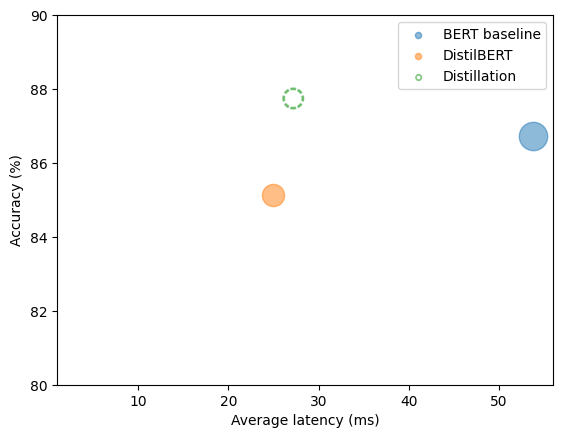

In [43]:
plot_metrics(perf_metrics, optim_type)

### second optimization technique: Making faster with Quantization

In [44]:
# quantization makes them much more efficient by representing the weights and activations with low-precision
# data types like 8-bit integer (INT8) instead of the usual 32-bit floating point (FP32). Reducing the number
# of bits means the resulting model requires less memory storage, and operations like matrix multiplication
# can be performed much faster with integer arithmetic. Remarkably, these performance gains can be realized
# with little to no loss in accuracy

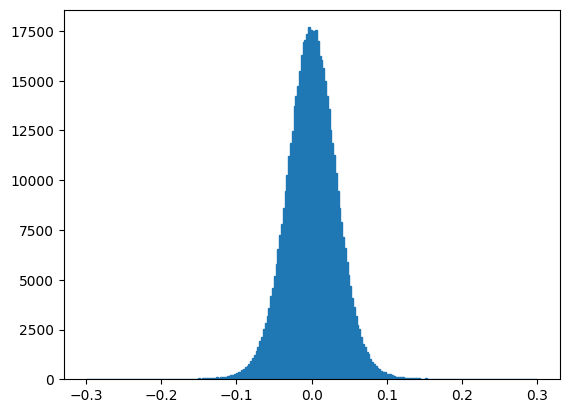

In [45]:
# the values of the weights are distributed in the small range [-0.1, 0.1] around zero:
state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

In [46]:
# to quantize this tensor as a signed 8-bit integer:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

In [47]:
# to obtain the quantized tensor:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -7,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   1],
        [ -9,  -6,   5,  ...,   0,   5,  -4],
        ...,
        [  5,   0,  13,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

In [48]:
# the same can be done using PyTorch:
dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -7,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   1],
        [ -9,  -6,   5,  ...,   0,   5,  -4],
        ...,
        [  5,   0,  13,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

In [49]:
# let’s compare how long it takes to compute the multiplication of two weight tensors with FP32 and INT8 values

In [57]:
# for the FP32 tensors, we can multiply them using PyTorch’s nifty @ operator:

In [56]:
%%timeit
weights @ weights

6.79 ms ± 188 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [58]:
# For the quantized tensors we need the QFunctional wrapper class so that we can
# perform operations with the special torch.qint8 data type:
q_fn = QFunctional()

In [59]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

8.22 ms ± 422 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [60]:
# quantization also reduces the memory storage requirements:
sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

3.999755879241598

In [68]:
# Implementing dynamic quantization in PyTorch:

In [66]:
from torch.quantization import quantize_dynamic

model_ckpt = "cafbr/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))


In [67]:
model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

#### Benchmarking Our Quantized Model

In [69]:
pipe = pipeline("text-classification", model=model_quantized,
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 132.40
Average latency (ms) - 30.70 +\- 4.60
Accuracy on test set - 0.885


C:\Users\cafbr\AppData\Local\Temp\ipykernel_13504\1075491845.py:16: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


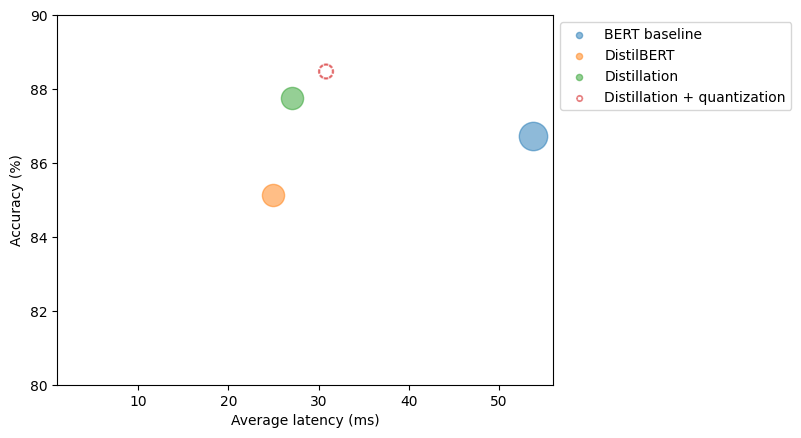

In [70]:
plot_metrics(perf_metrics, optim_type)

### third optimization technique:  Accelerate Inference with ONNX and the ONNX Runtime

In [71]:
# first need to set some OpenMP environment variables for ONNX:
os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"
# the OMP_NUM_THREADS environment variable sets the number of threads to use for parallel computations
# in the ONNX Runtime, while OMP_WAIT_POLICY=ACTIVE specifies that waiting threads should be active
# (i.e., using CPU processor cycles).

In [72]:
# convert our distilled model to the ONNX format
model_ckpt = "cafbr/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer,
        output=onnx_model_path, opset=12, pipeline_name="text-classification")

C:\Users\cafbr\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\convert_graph_to_onnx.py:379: FutureWarning: The `transformers.convert_graph_to_onnx` package is deprecated and will be removed in version 5 of Transformers
  warnings.warn(


ONNX opset version set to: 12
Loading pipeline (model: cafbr/distilbert-base-uncased-distilled-clinc, tokenizer: DistilBertTokenizerFast(name_or_path='cafbr/distilbert-base-uncased-distilled-clinc', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True))
Creating folder onnx
Using framework PyTorch: 1.11.0+cu113
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch'}
Ensuring inputs are in correct order
head_mask is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask']


C:\Users\cafbr\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\distilbert\modeling_distilbert.py:223: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)


In [73]:
# create an InferenceSession instance to feed inputs to the model:
def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

In [74]:
onnx_model = create_model_for_provider(onnx_model_path)

In [75]:
# test this out with an example from the test set
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

(1, 151)

In [76]:
# Once we have the logits above, we can get the predicted label by taking the argmax:
np.argmax(logits_onnx)

61

In [77]:
# which agrees with the ground truth label:
clinc_enc["test"][0]["labels"]

61

In [78]:
# The ONNX model is not compatible with the text-classification pipeline,
# so we’ll create our own class that mimics the core behavior:
class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy()
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [79]:
# We can then test this on our simple query to see if we recover the car_rental intent:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.97416955}]

In [80]:
# create a performance benchmark for ONNX models
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [81]:
# With our new benchmark, let’s see how our distilled model performs when converted to ONNX format:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.90
Average latency (ms) - 24.27 +\- 1.63
Accuracy on test set - 0.877


C:\Users\cafbr\AppData\Local\Temp\ipykernel_13504\1075491845.py:16: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


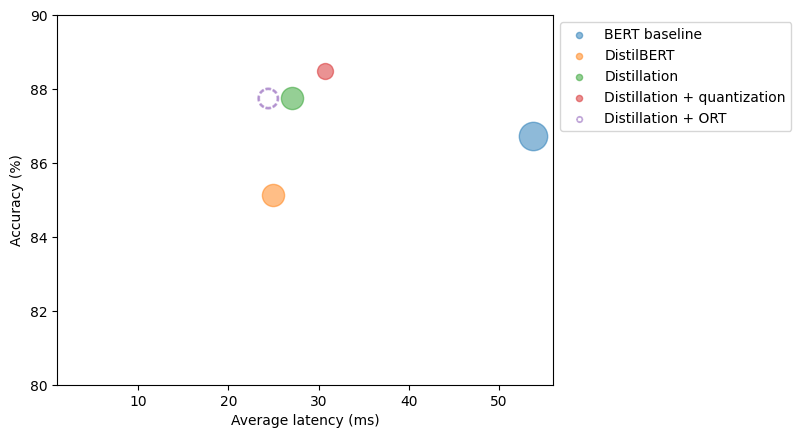

In [82]:
# converting to the ONNX format and using the ONNX Runtime has given our distilled model a boost in latency! 
plot_metrics(perf_metrics, optim_type)

In [85]:
# Let’s squeeze out a bit more performance by adding quantization to the mix:

In [86]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

Ignore MatMul due to non constant B: /[MatMul_47]
Ignore MatMul due to non constant B: /[MatMul_60]
Ignore MatMul due to non constant B: /[MatMul_129]
Ignore MatMul due to non constant B: /[MatMul_142]
Ignore MatMul due to non constant B: /[MatMul_211]
Ignore MatMul due to non constant B: /[MatMul_224]
Ignore MatMul due to non constant B: /[MatMul_293]
Ignore MatMul due to non constant B: /[MatMul_306]
Ignore MatMul due to non constant B: /[MatMul_375]
Ignore MatMul due to non constant B: /[MatMul_388]
Ignore MatMul due to non constant B: /[MatMul_457]
Ignore MatMul due to non constant B: /[MatMul_470]


In [87]:
# let’s run it through our benchmark:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 64.21
Average latency (ms) - 8.90 +\- 0.61
Accuracy on test set - 0.884


C:\Users\cafbr\AppData\Local\Temp\ipykernel_13504\1075491845.py:16: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


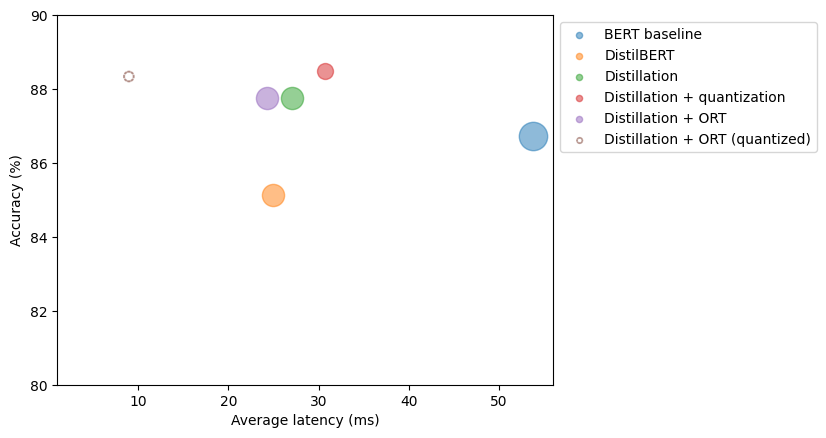

In [88]:
plot_metrics(perf_metrics, optim_type)